# Problem 1: Bayesian Optimization By Hand

While there are a variety of libraries that can be used to perform Bayesian optimization, it is important to understand the underlying process. In this problem, you will build a bayesian optimization pipeline by hand and use it to find 15 of the top 5% of materials in a dataset.

Taken as a whole, this problem may seem daunting. However, when broken into its components it is quite manageable. Recall the Bayesian optimization flow chart from the lectures that details to core components of the a bayesian optimization pipeline. Rather than trying to solve this problem all in one shot, we recommend building the pipeline one component at a time and making sure you understand it before moving on to the next component.

You are given the crossed barrel dataset, which shows the toughness of materials as a function of several 3D printer parameters. For learning purposes, we are going to pretend that we don't know the optimal parameters in advance and perform a simulated optimzation campaign to find them. Your task is to start with 5 random samples from the data and use Bayesian optimization to find the top 5% of candidates in the data. Use the gaussain process model included in the `scikit-learn` package as your surrogate model. We would like you to perform the optimization with two different acquisition functions: expected improvement and upper confidence bound. You will need to implement these acquisition functions by hand (don't worry it's easy). Your termination criteria will be when you have found at least 15 candidates from the top 5% of the materials in the dataset.

Your code will likely get very messy as you experiment and learn how to implement these components. However, clean code is an expectation in professional settings. Therefore, we are requiring that your final code by clean and commented (this includes function explanations) upon submission. 3pts will be assigned to this. If you are unsure if your code is clean enough, ask a TA or instructor for feedback.

**Specific Tasks**

Please show the following for both UCB and EI cases:
- How many iterations it took to find 15 candidates (should be less than 150)
- A plot of the 15 candidates you found relative to the entire dataset
- A plot of the number of candidates you found as a function of iteation count
- A plot of the best candidate you found as a function of the iteration count

Finally provide some commentary on the performance of your optimization campaigns. What surprised you about the results? What would you do differently if you were to do this in a real experimental setting?

## Upper Confidence Bound

In [14]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import random
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import r2_score
import numpy as np

# import data as a pandas dataframe
data = pd.read_csv("data/crossed_barrel_dataset.csv")

# create a array of the average values of each of the toughness parameters
# these will be the independent variables used to predict the target value
averaged_data = data.groupby(['n','theta','r','t']).mean().reset_index()

# the target value, or labels, of the independent variables will be toughness
target = averaged_data.pop('toughness')

# scale the averaged data array so that the relative magnitudes 
# of their values do not confuse the ML model
scaler = StandardScaler()
averaged_data_standardized = scaler.fit_transform(averaged_data)

# define a target value within the first standard deviation of the data
cutoff = target.quantile(0.5)

# generate five random indices to be used 
indices = random.sample(range(0,600),5)

# Use the randomly generated indices to select random data from the averaged data
# dataset as the starting points for our Bayesian optimization
starting_values = [averaged_data_standardized[i] for i in indices [:5]]

# define the corresponding labels to the data that was randomly selected
starting_values_target = [target[i] for i in indices [:5]]

# Use the radial basis function from sklearn
kernel = RBF()
# define our model as a Gaussian Process Regressor
surrogate_model = GaussianProcessRegressor(kernel=kernel)

# fit the GPR to the starting values
surrogate_model.fit(starting_values,starting_values_target)

# Define number of standard deviations for ucb to span
exploration_param = 1

# Draw function from GPR
mean_predictions, std_predictions = surrogate_model.predict(averaged_data_standardized, return_std=True)

# upper confidence bound
ucb = mean_predictions + exploration_param*std_predictions

# identify the data with the largest confidence interval (the one we are most unsure of)
indx_new_data = ucb.argmax()

n = 2
while np.isin(indx_new_data,indices).any():
    indx_new_data = np.argpartition(ucb, 1)[-n] # get nth largest 
    n = n + 1

new_dat_point = averaged_data_standardized[indx_new_data]
new_dat_point=new_dat_point.reshape(1,4)

starting_values=np.asarray(starting_values)

# append index of new datapoint to training index
indices.append(indx_new_data)

# define top 5 % of materials (find 30 largest toughness values in dataset of 600)
idx_top_5 = target.nlargest(30).index.values

# update training data
new_values = [averaged_data_standardized[i] for i in indices]
new_values_target = [target[i] for i in indices]

# check how many of the top 5% of toughness materials are in the training set
#num_top_mats_predicted = sum(round(target[idx_top_5],0).isin(round(pd.Series(mean_predictions[idx_top_5]),0)) == True)

found_indx = list([])
best_mat_pred = list([])

num_top_mats_predicted = 0
for i in idx_top_5:
    if (round(target[i],0) == round(mean_predictions[i],0)):
        found_indx.append(i)
        num_top_mats_predicted = num_top_mats_predicted + 1

if len(found_indx) != 0:
    best_mat_pred.append(max(target[found_indx]))
else:
    best_mat_pred.append(0)

# loop until stopping criterion is reached
# stopping criterion is when 15 of the top 5 % of materials are predicted

# track number of iterations the while loop goes through
num_iter = 0

num_iter_st = list([0])
ntms_st = list([num_top_mats_predicted])


while num_top_mats_predicted < 15 and num_iter < 150:

    # update starting values to include appended ucb data
    new_values = [averaged_data_standardized[i] for i in indices]
    new_values_target = [target[i] for i in indices]

    # fit the GPR to the new starting values
    surrogate_model.fit(new_values,new_values_target)

    # predict the toughness values for each data point along with the std expected at each point
    mean_predictions, std_predictions = surrogate_model.predict(averaged_data_standardized, return_std=True)

    # define upper confidence bound for each data point
    ucb = mean_predictions + exploration_param*std_predictions

    # identify the data with the largest ucb (the one we are most unsure of)
    # this data will be collected and used to retrain the dataset
    indx_new_data = ucb.argmax()

    # if the highest ucb is already in the training index, find the next highest ucb
    n = 2
    while np.isin(indx_new_data,indices).any():
        indx_new_data = np.argpartition(ucb, 1)[-n] # get nth largest 
        n = n + 1

    # create a variable for the data point that corresponds to the highest ucb
    new_dat_point = averaged_data_standardized[indx_new_data]
    new_dat_point = new_dat_point.reshape(1,4)

    # append index of new datapoint to training index
    indices.append(indx_new_data)
    
    #num_top_mats_predicted = sum(round(target[idx_top_5],0).isin(round(pd.Series(mean_predictions[idx_top_5]),0)) == True)
    num_top_mats_predicted = 0
    found_indx = list([])
    
    for i in idx_top_5:
        if (round(target[i],0) == round(mean_predictions[i],0)):
            found_indx.append(i)
            num_top_mats_predicted = num_top_mats_predicted + 1

    
    if len(found_indx) != 0:
        best_mat_pred.append(max(target[found_indx]))
    else:
        best_mat_pred.append(0)
    
    num_iter_st.append(num_iter)
    ntms_st.append(num_top_mats_predicted)


    num_iter = num_iter+1



c:\Miniconda3\envs\MatInformatics\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Miniconda3\envs\MatInformatics\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Miniconda3\envs\MatInformatics\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Miniconda3\envs\MatInformatics\lib\site-packages\sklearn\gaussian_proc

In [15]:
print("number of top materials predicted = ",num_top_mats_predicted)
print("number of iterations = ",num_iter)    

number of top materials predicted =  15
number of iterations =  73


In [16]:
import matplotlib.pyplot as plt

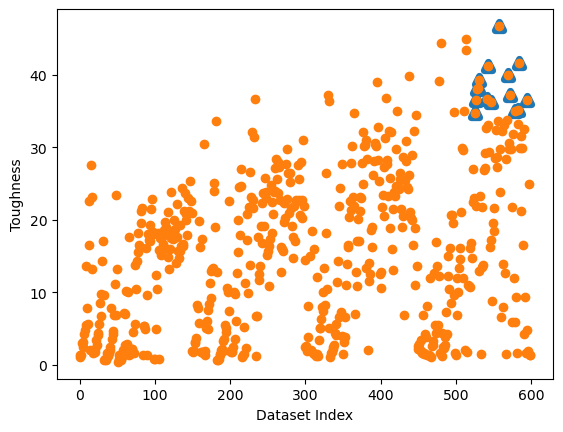

In [17]:
x = range(0,600)
plt.scatter(found_indx,target[found_indx],marker='^',linewidths=5)
plt.scatter(x,target[x])
plt.xlabel("Dataset Index")
plt.ylabel("Toughness")
plt.show()


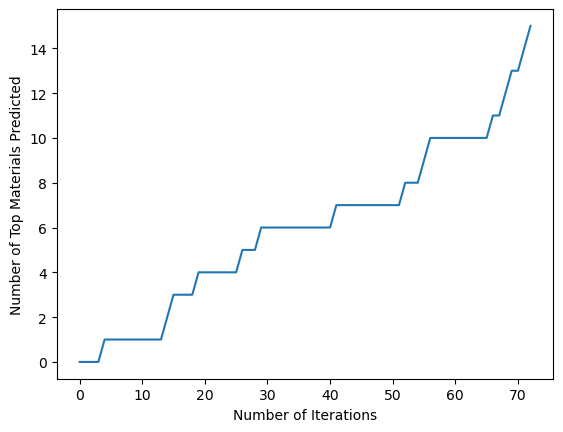

In [18]:
plt.plot(num_iter_st,ntms_st)
plt.xlabel("Number of Iterations")
plt.ylabel("Number of Top Materials Predicted")
plt.show()

[557, 584, 542, 569, 531, 529, 528, 572, 541, 594, 526, 546, 583, 579, 525]
<class 'int'>
[0, 0, 0, 0, 0, 36.46793078333334, 36.46793078333334, 36.46793078333334, 36.46793078333334, 36.46793078333334, 36.46793078333334, 36.46793078333334, 36.46793078333334, 36.46793078333334, 36.46793078333334, 41.57314338, 41.57314338, 41.57314338, 41.57314338, 41.57314338, 41.57314338, 41.57314338, 41.57314338, 41.57314338, 41.57314338, 41.57314338, 41.57314338, 41.57314338, 41.57314338, 41.57314338, 41.57314338, 41.57314338, 41.57314338, 41.57314338, 41.57314338, 41.57314338, 41.57314338, 41.57314338, 41.57314338, 41.57314338, 41.57314338, 41.57314338, 46.711404976666664, 46.711404976666664, 46.711404976666664, 46.711404976666664, 46.711404976666664, 46.711404976666664, 46.711404976666664, 46.711404976666664, 46.711404976666664, 46.711404976666664, 46.711404976666664, 46.711404976666664, 46.711404976666664, 46.711404976666664, 46.711404976666664, 46.711404976666664, 46.711404976666664, 46.7114049766

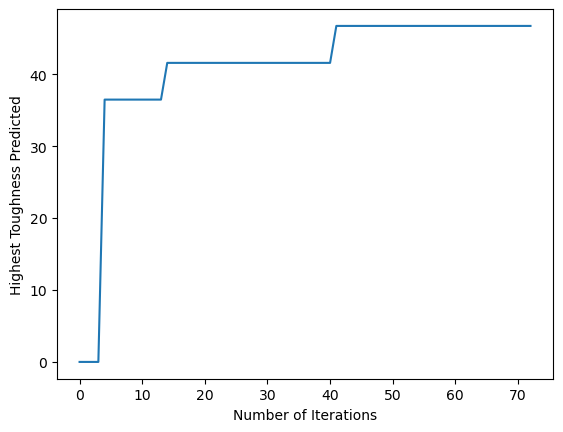

In [19]:
# Plot Best Candidate as Function of Iteration Count
print(found_indx)
print(type(len(found_indx)))

print(best_mat_pred)

plt.plot(num_iter_st,best_mat_pred)
plt.xlabel("Number of Iterations")
plt.ylabel("Highest Toughness Predicted")
plt.show()


## Expected Improvement

In [20]:
# Clear all variables

# this tends to crash my kernel
#import sys
#sys.modules[__name__].__dict__.clear()

In [21]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import random
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import r2_score
import numpy as np
import scipy.stats 


# import data as a pandas dataframe
data = pd.read_csv("data/crossed_barrel_dataset.csv")

# create a array of the average values of each of the toughness parameters
# these will be the independent variables used to predict the target value
averaged_data = data.groupby(['n','theta','r','t']).mean().reset_index()

# the target value, or labels, of the independent variables will be toughness
target = averaged_data.pop('toughness')

# scale the averaged data array so that the relative magnitudes 
# of their values do not confuse the ML model
scaler = StandardScaler()
averaged_data_standardized = scaler.fit_transform(averaged_data)

# define a target value within the first standard deviation of the data
cutoff = target.quantile(0.5)

# generate five random indices to be used 
indices = random.sample(range(0,600),5)

# Use the randomly generated indices to select random data from the averaged data
# dataset as the starting points for our Bayesian optimization
starting_values = [averaged_data_standardized[i] for i in indices [:5]]

# define the corresponding labels to the data that was randomly selected
starting_values_target = [target[i] for i in indices [:5]]

# Use the radial basis function from sklearn
kernel = RBF()
# define our model as a Gaussian Process Regressor
surrogate_model = GaussianProcessRegressor(kernel=kernel)

# fit the GPR to the starting values
surrogate_model.fit(starting_values,starting_values_target)

# Draw function from GPR
mean, stdev = surrogate_model.predict(averaged_data_standardized, return_std=True)

# Expected Improvement
max_mean = np.max(mean)
z = (mean - max_mean)/stdev
E_I = (mean - max_mean)*scipy.stats.norm.cdf(z)+stdev*scipy.stats.norm.pdf(z)

# identify the data with the largest expected improvement
indx_new_data = E_I.argmax()

n = 2
while np.isin(indx_new_data,indices).any():
    indx_new_data = np.argpartition(E_I, 1)[-n] # get nth largest 
    n = n + 1

new_dat_point = averaged_data_standardized[indx_new_data]
new_dat_point=new_dat_point.reshape(1,4)

starting_values=np.asarray(starting_values)

# append index of new datapoint to training index
indices.append(indx_new_data)

# define top 5 % of materials (find 30 largest toughness values in dataset of 600)
idx_top_5 = target.nlargest(30).index.values

# update training data
new_values = [averaged_data_standardized[i] for i in indices]
new_values_target = [target[i] for i in indices]

# count how many of the top 5% of toughness materials are correctly predicted by the model
found_indx = list([])
best_mat_pred = list([])

num_top_mats_predicted = 0
for i in idx_top_5:
    if (round(target[i],0) == round(mean[i],0)):
        found_indx.append(i)
        num_top_mats_predicted = num_top_mats_predicted + 1

# keep track of the index of the top materials that have been found
if len(found_indx) != 0:
    best_mat_pred.append(max(target[found_indx]))
else:
    best_mat_pred.append(0)

# loop until stopping criterion is reached
# stopping criterion is when 15 of the top 5 % of materials are predicted

# track number of iterations the while loop goes through
num_iter = 0

num_iter_st = list([0])
ntms_st = list([num_top_mats_predicted])


while num_top_mats_predicted < 15 and num_iter < 150:

    # update starting values to include appended ucb data
    new_values = [averaged_data_standardized[i] for i in indices]
    new_values_target = [target[i] for i in indices]

    # fit the GPR to the new starting values
    surrogate_model.fit(new_values,new_values_target)

    # predict the toughness values for each data point along with the std expected at each point
    mean, stdev = surrogate_model.predict(averaged_data_standardized, return_std=True)

    # Expected Improvement
    max_mean = np.max(mean)
    z = (mean - max_mean)/stdev
    E_I = (mean - max_mean)*scipy.stats.norm.cdf(z)+stdev*scipy.stats.norm.pdf(z)

    # identify the data with the largest expected improvement
    indx_new_data = E_I.argmax()

    # if the highest ucb is already in the training index, find the next highest ucb
    n = 2
    while np.isin(indx_new_data,indices).any():
        indx_new_data = np.argpartition(E_I, 1)[-n] # get nth largest 
        n = n + 1

    # create a variable for the data point that corresponds to the highest ucb
    new_dat_point = averaged_data_standardized[indx_new_data]
    new_dat_point = new_dat_point.reshape(1,4)

    # append index of new datapoint to training index
    indices.append(indx_new_data)
    
    # count how many of the top materials are correctly predicted by the model
    num_top_mats_predicted = 0
    found_indx = list([])
    
    for i in idx_top_5:
        if (round(target[i],0) == round(mean[i],0)):
            found_indx.append(i)
            num_top_mats_predicted = num_top_mats_predicted + 1

    # keep track of the indices of the top materials that have been correctly predicted
    if len(found_indx) != 0:
        best_mat_pred.append(max(target[found_indx]))
    else:
        best_mat_pred.append(0)
    
    num_iter_st.append(num_iter)
    ntms_st.append(num_top_mats_predicted)


    num_iter = num_iter+1


c:\Miniconda3\envs\MatInformatics\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Miniconda3\envs\MatInformatics\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Miniconda3\envs\MatInformatics\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Miniconda3\envs\MatInformatics\lib\site-packages\sklearn\gaussian_proc

In [22]:
print("number of top materials predicted = ",num_top_mats_predicted)
print("number of iterations = ",num_iter)    

number of top materials predicted =  15
number of iterations =  75


In [23]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Toughness')

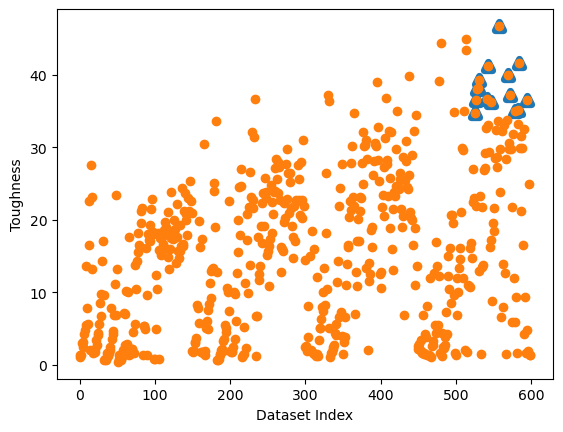

In [24]:
x = range(0,600)
plt.scatter(found_indx,target[found_indx],marker='^',linewidths=5)
plt.scatter(x,target[x])
plt.xlabel("Dataset Index")
plt.ylabel("Toughness")

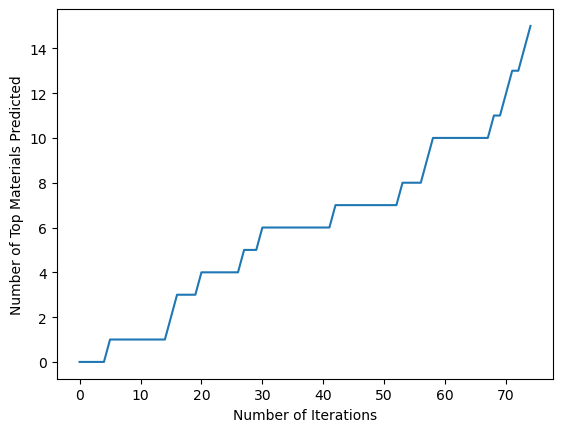

In [25]:
plt.plot(num_iter_st,ntms_st)
plt.xlabel("Number of Iterations")
plt.ylabel("Number of Top Materials Predicted")
plt.show()

[557, 584, 542, 569, 531, 529, 528, 572, 541, 594, 526, 546, 583, 579, 525]
<class 'int'>
[0, 0, 0, 0, 0, 0, 36.46793078333334, 36.46793078333334, 36.46793078333334, 36.46793078333334, 36.46793078333334, 36.46793078333334, 36.46793078333334, 36.46793078333334, 36.46793078333334, 36.46793078333334, 41.57314338, 41.57314338, 41.57314338, 41.57314338, 41.57314338, 41.57314338, 41.57314338, 41.57314338, 41.57314338, 41.57314338, 41.57314338, 41.57314338, 41.57314338, 41.57314338, 41.57314338, 41.57314338, 41.57314338, 41.57314338, 41.57314338, 41.57314338, 41.57314338, 41.57314338, 41.57314338, 41.57314338, 41.57314338, 41.57314338, 41.57314338, 46.711404976666664, 46.711404976666664, 46.711404976666664, 46.711404976666664, 46.711404976666664, 46.711404976666664, 46.711404976666664, 46.711404976666664, 46.711404976666664, 46.711404976666664, 46.711404976666664, 46.711404976666664, 46.711404976666664, 46.711404976666664, 46.711404976666664, 46.711404976666664, 46.711404976666664, 46.7114049

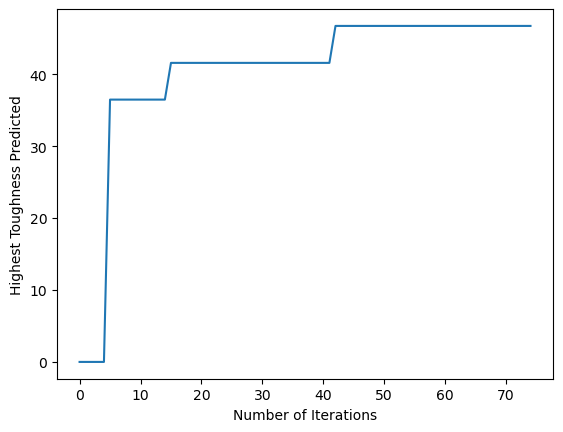

In [26]:
# Plot Best Candidate as Function of Iteration Count
print(found_indx)
print(type(len(found_indx)))

print(best_mat_pred)

plt.plot(num_iter_st,best_mat_pred)
plt.xlabel("Number of Iterations")
plt.ylabel("Highest Toughness Predicted")
plt.show()